### Load Test Data and Trained APG Sampler

In [3]:
%matplotlib inline
import os
import torch
import numpy as np
from apgs.bmnist.apg_training import init_models
from apgs.bmnist.affine_transformer import Affine_Transformer

CUDA = torch.cuda.is_available()
device = torch.device('cuda:1')
data_dir = '../../data/bmnist/'
timesteps, num_digits, frame_pixels, mnist_pixels, num_hidden_digit, num_hidden_coor, z_where_dim, z_what_dim = 10, 3, 96, 28, 400, 400, 2, 10
data_paths = []
for file in os.listdir(data_dir + 'train/'):
    data_paths.append(os.path.join(data_dir, 'train', file))
model_version = 'apg-full-adam-bmnist-num_sweeps=5-num_samples=20'
models = init_models(frame_pixels, mnist_pixels, num_hidden_digit, num_hidden_coor, z_where_dim, z_what_dim, CUDA, device, model_version, lr=None)
AT = Affine_Transformer(frame_pixels, mnist_pixels, CUDA, device)  

### Visualize Samples

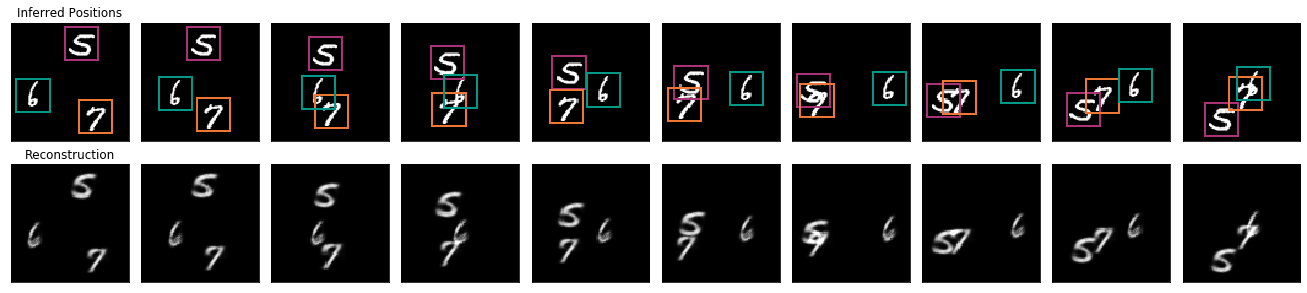

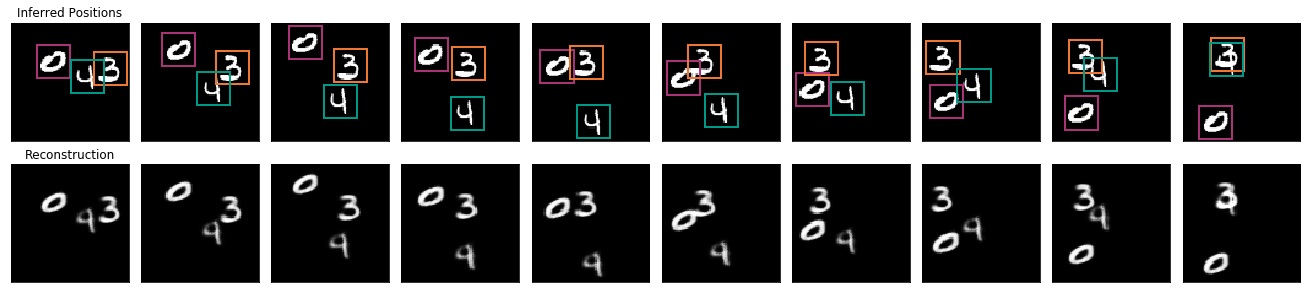

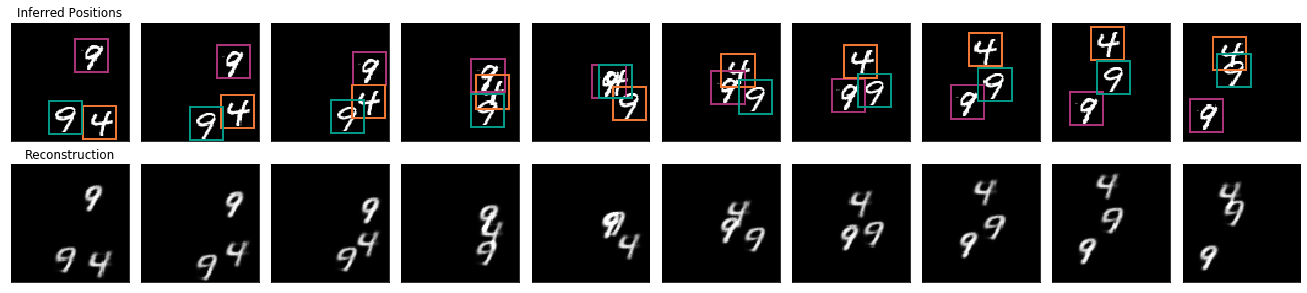

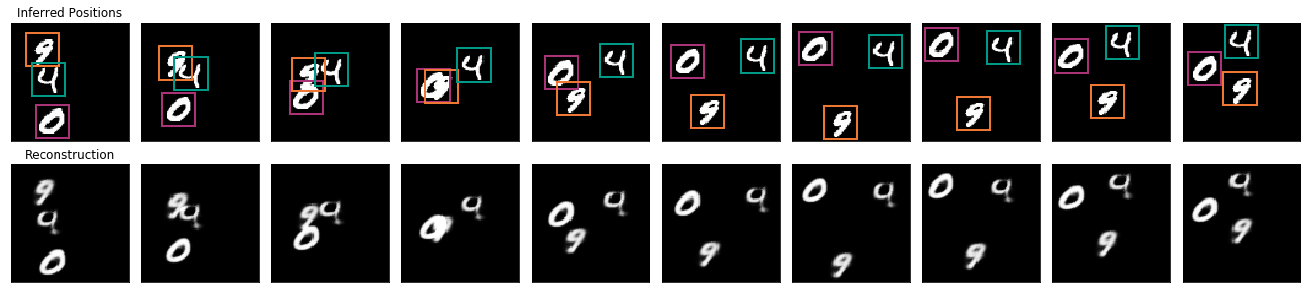

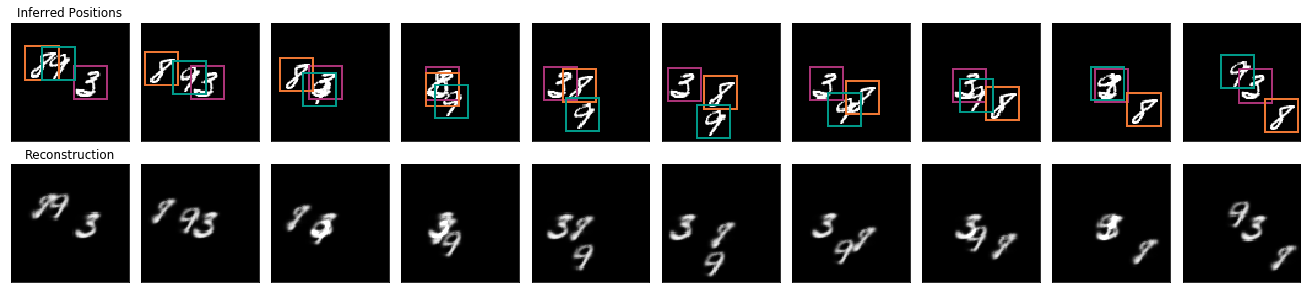

In [4]:
from apgs.resampler import Resampler
from apgs.bmnist.objectives import apg_objective
from apgs.bmnist.evaluation import viz_samples
from random import shuffle
batch_size, num_sweeps = 5, 10
shuffle(data_paths)
data = torch.from_numpy(np.load(data_paths[0])).float()[:batch_size].unsqueeze(0)
mnist_mean = torch.from_numpy(np.load('mnist_mean.npy')).float()
mnist_mean = mnist_mean.repeat(batch_size, num_digits, 1, 1).unsqueeze(0)
if CUDA:
    data = data.cuda().to(device)
    mnist_mean = mnist_mean.cuda().to(device)
result_flags = {'loss_required' : False, 'ess_required' : False, 'mode_required' : True, 'density_required': False}
trace = apg_objective(models, AT, data, num_digits, result_flags, num_sweeps, Resampler('systematic', 1, CUDA, device), mnist_mean)
viz_samples(data.squeeze(0).cpu(), trace, num_sweeps, num_digits)

### Computing log joint across all methods

In [ ]:
from apgs.bmnist.evaluation import density_all_instances
from random import shuffle
sample_size, num_sweeps = 1000, 10
lf_step_size, lf_num_steps, bpg_factor = 1e-4, [1, 5, 10], 100
density_all_instances(models, AT, data_paths, sample_size, num_digits, z_where_dim, z_what_dim, num_sweeps, lf_step_size, lf_num_steps, bpg_factor, CUDA, device)

In [9]:
import numpy as np
rws_f = open('results/ema-apg-first-adam-bmnist-num_sweeps=5-num_samples=20.txt', 'r')
apg_f = open('results/ema-apg-last-adam-bmnist-num_sweeps=5-num_samples=20.txt', 'r')
snr = {'rws' : [], 'apg' : []}
for line in rws_f.readlines():
    line = line.strip().split(', ')
    snr['rws'].append(float(line[-1][4:]))
for line in apg_f.readlines():
    line = line.strip().split(', ')
    snr['apg'].append(float(line[-1][4:]))   
rws_f.close()
apg_f.close()
for key in snr.keys():
    snr[key] = np.reshape(np.array(snr[key]), (500, 10))[:, -1]
rws_f = open('results/log-apg-first-adam-bmnist-num_sweeps=5-num_samples=20.txt', 'r')
apg_f = open('results/log-apg-last-adam-bmnist-num_sweeps=5-num_samples=20.txt', 'r')
density = {'rws' : [], 'apg' : []}
for line in rws_f.readlines():
    line = line.strip().split(', ')
    density['rws'].append(float(line[-1][9:]))
for line in apg_f.readlines():
    line = line.strip().split(', ')
    density['apg'].append(float(line[-1][9:]))  
rws_f.close()
apg_f.close()
for key in density.keys():
    density[key] = np.array(density[key])

ValueError: cannot reshape array of size 4823 into shape (500,10)

Text(0.5, 1.0, '$\\log p(x, z)$')

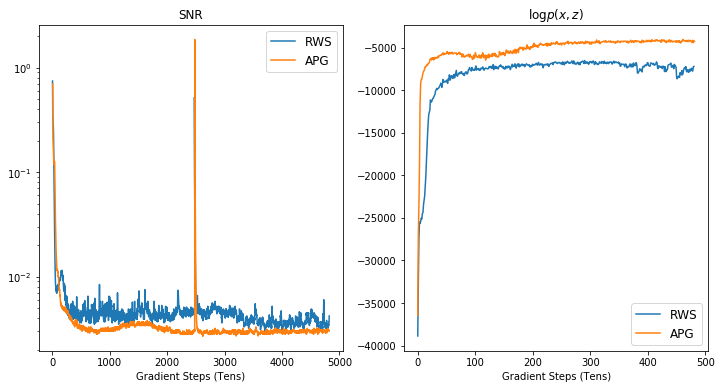

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(snr['rws'], label='RWS')
ax1.plot(snr['apg'], label='APG')
ax1.legend(fontsize=12)
ax1.set_xlabel('Gradient Steps (Tens)')
ax1.set_title('SNR')
ax1.set_yscale('log')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(density['rws'], label='RWS')
ax2.plot(density['apg'], label='APG')
ax2.legend(fontsize=12)
ax2.set_xlabel('Gradient Steps (Tens)')
ax2.set_title(r'$\log p(x, z)$')


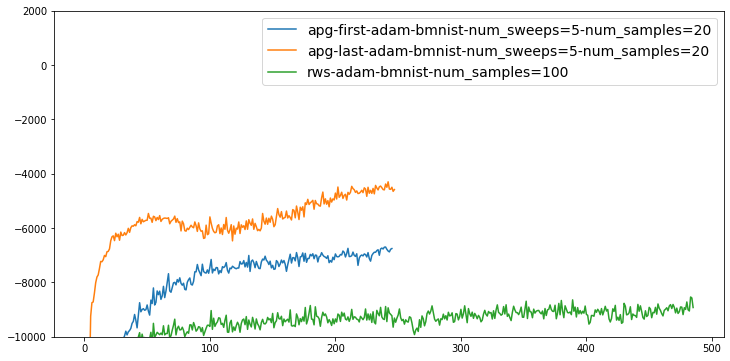

In [21]:
plot_training_convergence(model_names)